<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/ITD_Based_MLP_KAN_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training Vanilla MLP
Epoch 0, Loss: 1.4579
Epoch 50, Loss: 0.5229
Epoch 100, Loss: 0.4662
Epoch 150, Loss: 0.4149
Epoch 200, Loss: 0.3687
Epoch 250, Loss: 0.3272
Epoch 300, Loss: 0.2899
Epoch 350, Loss: 0.2566
Epoch 400, Loss: 0.2268
Epoch 450, Loss: 0.2002

Training ITD-based MLP
Epoch 0, Loss: 3.0899
Epoch 50, Loss: 2.8087
Epoch 100, Loss: 0.0289
Epoch 150, Loss: 0.0001
Epoch 200, Loss: 0.0000
Epoch 250, Loss: 0.0000
Epoch 300, Loss: 0.0000
Epoch 350, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 450, Loss: 0.0000
Early stopping at epoch 454


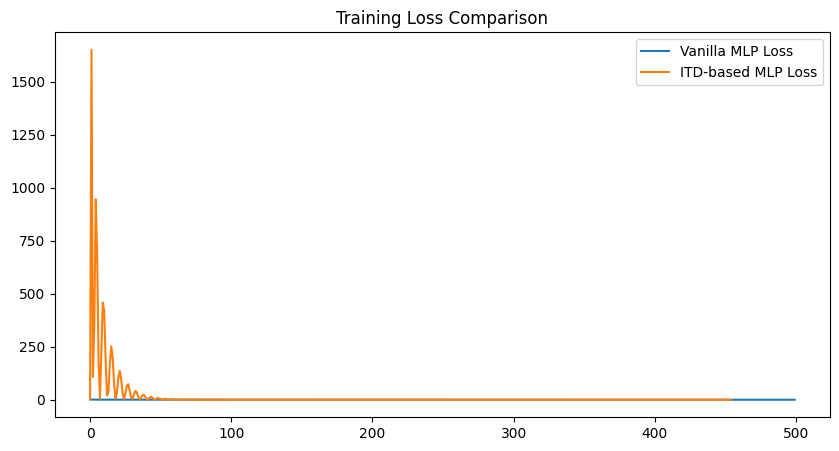

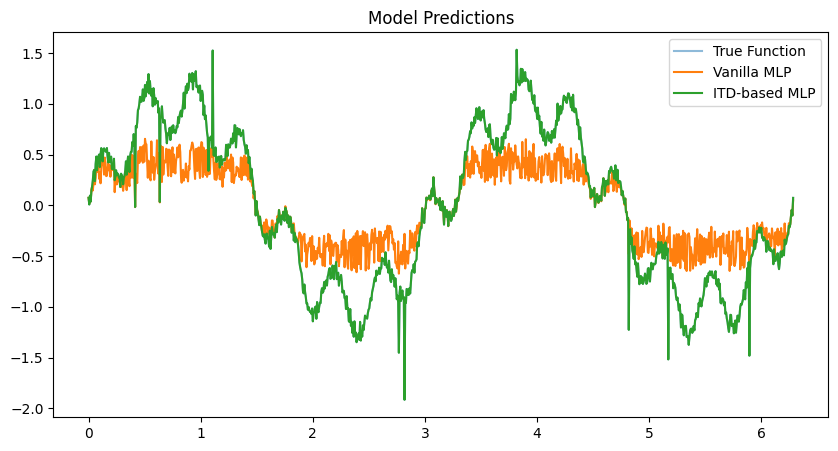

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate multi-scale pattern data
def generate_data(n_samples=1000):
    X = np.linspace(0, 2 * np.pi, n_samples)
    # Slow-moving trend
    slow_trend = np.sin(2 * X)
    # Fast oscillations
    fast_oscillations = 0.3 * np.sin(15 * X)
    # Localized spikes
    spikes = np.zeros_like(X)
    spike_indices = np.random.choice(n_samples, size=10, replace=False)
    spikes[spike_indices] = np.random.uniform(-1, 1, size=10)
    # Combine components
    y = slow_trend + fast_oscillations + spikes + 0.05 * np.random.randn(n_samples)
    return X.reshape(-1, 1), y.reshape(-1, 1)

# Accelerated ITDLayer using a tridiagonal system for spline coefficients.
# This layer now expects input x of shape (batch, L, 1) and returns (batch, scales, L).
class AcceleratedITDLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        input_dim: number of features per time point (typically 1)
        output_dim: number of grid scales (we use this many scales)
        """
        super(AcceleratedITDLayer, self).__init__()
        self.output_dim = output_dim
        # Learnable bias for each scale
        self.bias = nn.Parameter(torch.randn((1)))

    def forward(self, x):
        # x shape: (batch, L, 1)
        batch, L, _ = x.shape
        # We choose grid sizes linearly spaced between 10 and 100, for each scale.
        scales = torch.linspace(2, L//2, self.output_dim, device=x.device)
        outputs = []
        for grid_size in scales:
            grid_size_int = int(grid_size.item())
            # Compute grid indices along the time axis (shared across the batch)
            indices = torch.linspace(0, L - 1, grid_size_int, device=x.device).long()  # (grid_size_int,)
            # Extract “extrema” values from the signal at these grid points (shape: (batch, grid_size_int))
            ext_vals = x[:, indices, 0]
            # Compute spacing h (as float)
            h = (indices[1:] - indices[:-1]).float()  # shape: (grid_size_int - 1)

            # If there are interior points, solve for the second derivatives (b) via a tridiagonal system
            if grid_size_int > 2:
                # Build right-hand side r for interior points (for i = 1...grid_size_int-2)
                # r has shape (batch, grid_size_int - 2)
                r = 6 * (
                    (ext_vals[:, 2:] - ext_vals[:, 1:-1]) / h[1:].unsqueeze(0)
                    - (ext_vals[:, 1:-1] - ext_vals[:, :-2]) / h[:-1].unsqueeze(0)
                )
                n = r.shape[1]  # number of interior points
                # Construct the tridiagonal matrix A of shape (n, n)
                diag = 2 * (h[:-1] + h[1:])
                A = torch.zeros((n, n), device=x.device, dtype=x.dtype)
                for i in range(n):
                    A[i, i] = diag[i]
                    if i > 0:
                        A[i, i-1] = h[i]  # lower diagonal
                    if i < n - 1:
                        A[i, i+1] = h[i+1]  # upper diagonal
                # Expand A over the batch dimension and solve A * b_interior = r^T for each batch element.
                A_expanded = A.unsqueeze(0).expand(batch, -1, -1)  # shape: (batch, n, n)
                r_unsq = r.unsqueeze(-1)  # shape: (batch, n, 1)
                b_interior = torch.linalg.solve(A_expanded, r_unsq).squeeze(-1)  # shape: (batch, n)
            else:
                b_interior = torch.empty((batch, 0), device=x.device, dtype=x.dtype)

            # Assemble full b with natural spline boundary conditions (b=0 at endpoints)
            b = torch.zeros((batch, grid_size_int), device=x.device, dtype=x.dtype)
            if grid_size_int > 2:
                b[:, 1:-1] = b_interior

            # Now, for each segment between consecutive grid points, compute the cubic spline interpolation.
            baseline = torch.zeros((batch, L), device=x.device, dtype=x.dtype)
            for j in range(grid_size_int - 1):
                start = indices[j].item()
                end = indices[j+1].item()
                L_seg = end - start  # number of steps in this segment
                # Create a normalized parameter t going from 0 to 1 over the segment (shape: (L_seg+1,))
                t = torch.linspace(0, 1, L_seg + 1, device=x.device, dtype=x.dtype).unsqueeze(0)  # (1, L_seg+1)
                # Cubic spline formula:
                # S(t) = (1-t)*y_j + t*y_{j+1} +
                #        (h_j^2/6)*((1-t)^3 - (1-t))*b_j + (h_j^2/6)*(t^3 - t)*b_{j+1}
                seg = ((1 - t) * ext_vals[:, j:j+1] + t * ext_vals[:, j+1:j+2] +
                       (h[j]**2 / 6) * (((1 - t)**3 - (1 - t)) * b[:, j:j+1] +
                                        ((t**3 - t)) * b[:, j+1:j+2]))
                baseline[:, start:end+1] = seg
            # The output for this grid scale has shape (batch, L); add a new channel dimension along scale.
            outputs.append(baseline.unsqueeze(1))  # shape (batch, 1, L)
        # Concatenate over the scale dimension so that the full output is (batch, scales, L)
        out = torch.cat(outputs, dim=1)
        # Add the learnable bias (reshape bias to (1, scales, 1) for broadcasting)
        out = out + self.bias
        return out

# Vanilla MLP operating on the entire signal.
# It flattens the input (batch, L, 1) into (batch, L) and maps it to (batch, L) before reshaping.
class VanillaMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(VanillaMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_length, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1) -> flatten to (batch, L)
        batch, L, _ = x.shape
        x_flat = x.view(batch, -1)
        out = self.fc(x_flat)
        # Reshape output to (batch, L, 1)
        return out.view(batch, L, 1)

# ITD-based MLP that uses the AcceleratedITDLayer.
# Note: It now takes an additional argument 'input_length' to know how many time steps to expect.
class ITDMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(ITDMLP, self).__init__()
        # The ITD layer produces an output of shape (batch, hidden_dim, input_length)
        self.itd = AcceleratedITDLayer(input_dim=1, output_dim=hidden_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(hidden_dim * input_length, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1)
        x_itd = self.itd(x)         # -> (batch, hidden_dim, L)
        x_flat = x_itd.view(x_itd.size(0), -1)  # -> (batch, hidden_dim * L)
        out = self.fc(x_flat)       # -> (batch, output_length)
        return out.view(x.size(0), -1, 1)  # reshape to (batch, L, 1)

# Training loop
def train(model, X_train, y_train, epochs=500, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        if loss.item() < 1e-12:
            print(f"Early stopping at epoch {epoch}")
            break
    return losses

# Main demo
# Get data and add a batch dimension (batch size = 1)
X, y = generate_data(n_samples=1000)
X_train = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
input_length = X_train.shape[1]

# Initialize models
vanilla_mlp = VanillaMLP(input_length=input_length, hidden_dim=20, output_length=input_length)
itd_mlp = ITDMLP(input_length=input_length, hidden_dim=20, output_length=input_length)

# Train models
print("\nTraining Vanilla MLP")
vanilla_losses = train(vanilla_mlp, X_train, y_train)

print("\nTraining ITD-based MLP")
itd_losses = train(itd_mlp, X_train, y_train)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(vanilla_losses, label="Vanilla MLP Loss")
plt.plot(itd_losses, label="ITD-based MLP Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

# Plot predictions (squeeze out batch and feature dimensions for plotting)
with torch.no_grad():
    vanilla_pred = vanilla_mlp(X_train).squeeze(0).cpu().numpy()  # shape: (1000, 1)
    itd_pred = itd_mlp(X_train).squeeze(0).cpu().numpy()          # shape: (1000, 1)

plt.figure(figsize=(10, 5))
plt.plot(X, y, label="True Function", alpha=0.5)
plt.plot(X, vanilla_pred, label="Vanilla MLP")
plt.plot(X, itd_pred, label="ITD-based MLP")
plt.legend()
plt.title("Model Predictions")
plt.show()



In [34]:
print(np.sum(np.abs(y-vanilla_pred)))
print(np.sum(np.abs(y-itd_pred)))


315.04369281808493
0.00033154341266900325
